# Post Translational Modification of a Protein - PROTOTYPE

This notebook demonstrates Open Force Field's prototype workflow for simulating a post-translationally modified protein.

We'd love to know your thoughts! Please submit feedback as an [issue] on the [`ptm_prototype` repository]

[`ptm_prototype` repository]: https://github.com/openforcefield/ptm_prototype
[issue]: https://github.com/openforcefield/ptm_prototype/issues/new

### Outline

1. Prepare a residue definition for the PTM residue
2. Load a PDB file containing the PTM residue
3. Solvate with the OpenFF PackMOL wrapper
4. Parametrize the solvated system using a combination of the Sage and FF14sb force fields and the NAGL graph charge package
5. Run a short simulation in OpenMM

To achieve a high-quality protein simulation, we apply as many parameters as possible from the SMIRNOFF port of Amber ff14sb. This includes charges, LJ parameters, and valence parameters for the canonical amino acids and NME/ACE caps. As with all SMIRNOFF-format force fields, these are applied via direct chemical perception as specified by SMARTS substructures. The remaining atoms LJ and valence parameters are filled in from Sage, while charges come from NAGL. NAGL allows AM1BCC partial charges for the entire protein to be computed from a graph neural network without having to run a much more expensive QC calculation on such a large molecule.

We'll perform most of our imports ahead of time, but API points prepared for this prototype will be imported in the cells in which they're used so they stand out. These API points may eventually be shipped in OpenFF packages after we get feedback on them!

In [7]:
import openmm
from ipywidgets import Image
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

## Prepare a residue definition for the PTM residue

The new Pablo PDB loader uses a unified [`ResidueDefinition`] dataclass to specify how to load a particular residue. Residues are loaded by matching atom names from the PDB file to the residue definitions defined for that residue name, and using the chemical information from the `ResidueDefinition` to determine the detailed chemical information needed to load an OpenFF Topology. Multiple residue definitions can be provided for a given residue name; if they disagree about how to assign chemical information to a particular residue in a PDB file, an error is raised. Residue definitions are provided to the PDB loader as a mapping from residue names to lists of residue definitions:

```py
residue_database: Mapping[str, list[ResidueDefinition]]
```

The default residue database used by Pablo is `CCD_RESIDUE_DEFINITION_CACHE`. This object presents the `Mapping` interface, and so residues can be read just like from a dictionary. Behind the scenes, the cache downloads and caches CIF files from the CCD, processes them into residue definitions, and patches them to improve compatibility with diverse PDB files. For example, we can take a look at the CCD's cysteine definition:

[`ResidueDefinition`]: https://openff-pablo.readthedocs.io/en/latest/api/generated/openff.pablo.ResidueDefinition.html

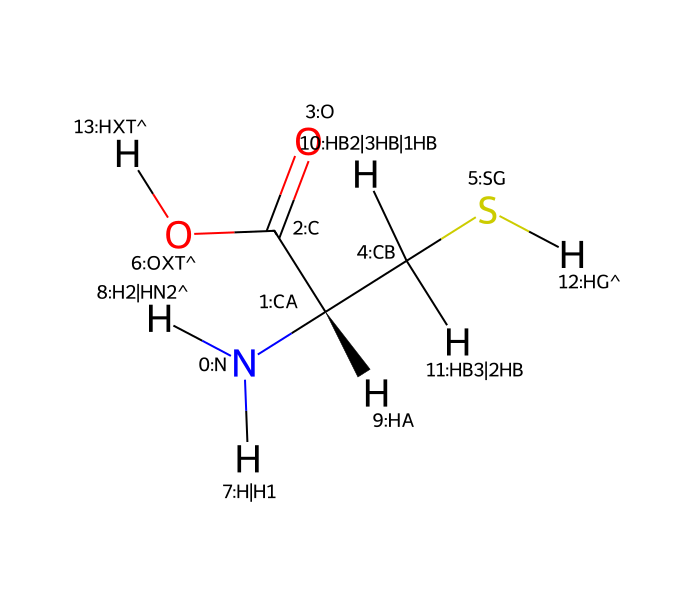

In [8]:
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from ptm_prototype import draw_molecule

cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
draw_molecule(
    cysteine,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(cysteine.atoms)
    },
)

Residue definitions support being written to and read from OpenFF `Molecule` objects so that they can be visualized and prepared with existing tools. In this depiction, each atom is labeled by its index in the molecule, the possible names it may have in a PDB file, and then finally a caret ("^") if it is absent when a bond is formed between this residue and another.

Our post-translationally modified protein contains a cysteine residue that has been labeled with a fluorescein maleimide dye. Labelling occurs in the lab via a synthetic thiol-maleimide "click" reaction that is specific to cysteine residues in proteins. To prepare the residue definition for the post-translationally modified residue, we will use the following SMARTS reaction to prepare the PTM residue from the maleimide and cysteine:

In [9]:
thiol_maleimide_click_smarts = (
    "[C:10]-[S:1]-[H:2]"
    + "."
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1"
    + ">>"
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1"
)

rxn = ReactionFromSmarts(thiol_maleimide_click_smarts)
d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(
    ReactionFromSmarts(thiol_maleimide_click_smarts), highlightByReactant=True
)
Image(value=d2d.GetDrawingText())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01,\x08\x02\x00\x00\x00\xb4O@m\x00\x00…

Next, we'll load the maleimide from an SDF file. This could come from any of the usual sources of an OpenFF `Molecule`, including an RDKit molecule object or SMILES string. We'll also generate atom names; these would be appropriate to use if you haven't already prepared the PDB file and have access to the atom names that will be written out, but to load an existing PDB file they'll have to be changed later.

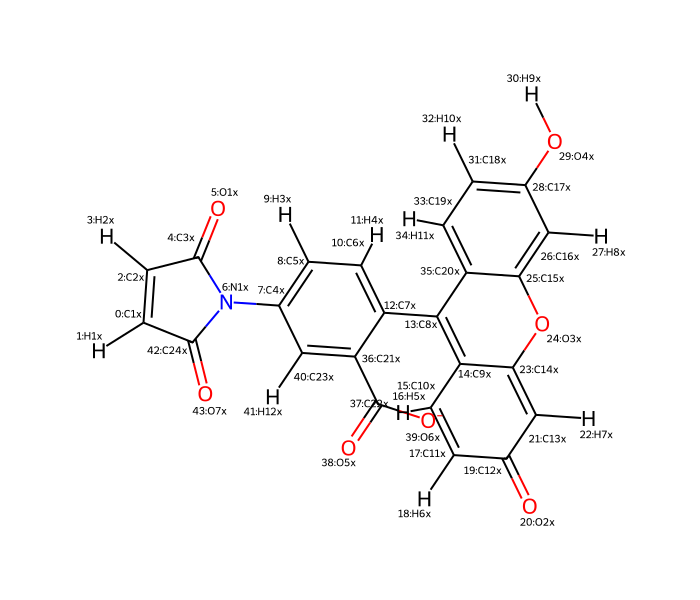

In [10]:
maleimide = Molecule.from_file("maleimide.sdf")
maleimide.generate_unique_atom_names()

draw_molecule(
    maleimide,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(maleimide.atoms)
    },
)

Now, we'll perform the reaction with the prototype `react()` function. `react()` takes a list of reactants and a reaction SMARTS and produces a list of the possible outcomes of the reaction, each represented by a list of product `Molecule` objects. For a single-product reaction that can only happen in a single way given the reactants, this is a single `Molecule` object wrapped in two lists.

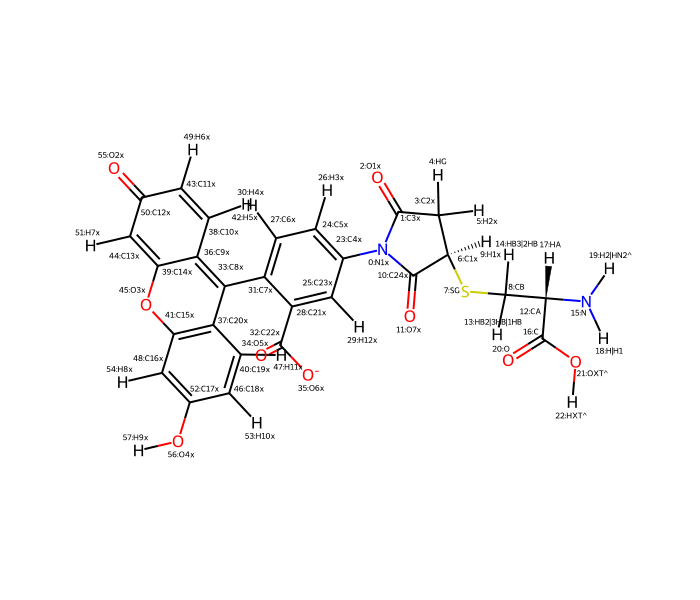

In [11]:
from ptm_prototype import react

products = list(react([cysteine, maleimide], thiol_maleimide_click_smarts))
dye = products[0][0]


draw_molecule(
    dye,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(dye.atoms)
    },
)

Notice that the atom names (along with all other properties) of the reactants has been preserved; this is the main value-add of the `react()` function over using the RDKit SMARTS reaction machinery directly.

Atom names are tricky; we've generated atom names automatically, but they almost certainly won't match what you have in a PDB. You could:

1. Modify the PDB to use the above atom names, or
2. Modify the substructure atom names to match the PDB file, or
3. Match based on connectivity rather than atom names. This requires CONECT records in the PDB, and is not yet supported by the new loader (coming soon!)

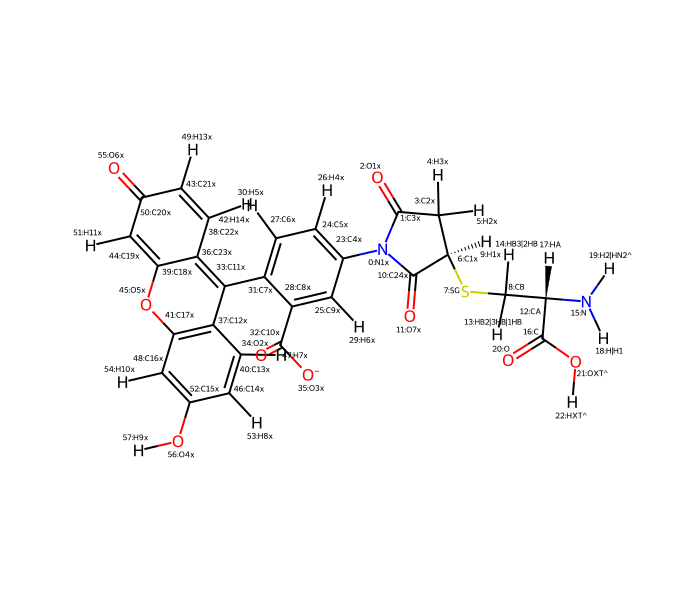

In [12]:
name_corrections = {
    4: "H3x",
    25: "C9x",
    26: "H4x",
    28: "C8x",
    29: "H6x",
    30: "H5x",
    32: "C10x",
    33: "C11x",
    34: "O2x",
    35: "O3x",
    36: "C23x",
    37: "C12x",
    38: "C22x",
    39: "C18x",
    40: "C13x",
    41: "C17x",
    42: "H14x",
    43: "C21x",
    44: "C19x",
    45: "O5x",
    46: "C14x",
    47: "H7x",
    49: "H13x",
    50: "C20x",
    51: "H11x",
    52: "C15x",
    53: "H8x",
    54: "H10x",
    55: "O6x",
}

for i, name in name_corrections.items():
    # assert dye.atom(i).name != name, f"{i}:{name}=={dye.atom(i).name}"
    dye.atom(i).name = name

draw_molecule(
    dye,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(dye.atoms)
    },
)

Now that we've prepared the molecule we want to load, we need to make it into a `ResidueDefinition`. `ResidueDefinition` has many construction methods for preparation from various different kinds of information; we'd like to support many such methods, so if you have suggestions please [let us know!].

[let us know!]:https://github.com/openforcefield/ptm_prototype/issues/new

In [13]:
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND

dye_resdef = ResidueDefinition.from_molecule(
    molecule=dye,
    residue_name="DYE",
    linking_bond=PEPTIDE_BOND,
)

The `linking_bond` argument, similar to the `crosslink_bond` argument not demonstrated here, specifies how bonds are formed between different residues. For common polymers, we intend to provide standard bonds in the `openff.pablo.chem` module, but you can also define your own; see the [`ResidueDefinition.linking_bond` documentation].

[`ResidueDefinition.linking_bond` documentation]: https://openff-pablo.readthedocs.io/en/latest/api/generated/openff.pablo.ResidueDefinition.html#openff.pablo.ResidueDefinition.linking_bond

## Load a PDB file containing the PTM residue

Now, we just load the PDB file using the CCD residue definition cache augmented with our new residue. Note that at the moment, this only matches based on atom names, but we will soon add support for connectivity-based matches. This means that at the moment, every atom name in the residue must match a synonym from the residue definition, but in the future we will be able to identify this residue from CONECT records as an alternative.

In [62]:
def draw_mol_with_atom_names(mol_to_draw):
    return draw_molecule(
        mol_to_draw,
        width=700,
        height=600,
        atom_notes={
            i: (
                f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
                + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
            )
            for i, atom in enumerate(mol_to_draw.atoms)
        },
    )

In [ ]:
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb


with open('system.pdb') as of:
    with open('system_renamed_residues.pdb','w') as ofw:
        for line in of.readlines():
            ofw.write(line.replace("TH4", "THR").
                replace("LY6", "LYS").
                replace("SE9", "SER").
                replace("A10", "ASP").
                replace("G12", "GLU").
                replace("G13", "GLU"))
            

In [23]:
CCD_RESIDUE_DEFINITION_CACHE['THR'][0].atoms#.to_openff_molecule()

(AtomDefinition(name='N', synonyms=(), symbol='N', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='CA', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo='S'),
 AtomDefinition(name='C', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='O', synonyms=(), symbol='O', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='CB', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo='R'),
 AtomDefinition(name='OG1', synonyms=(), symbol='O', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='CG2', synonyms=(), symbol='C', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='OXT', synonyms=(), symbol='O', leaving=True, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='H', synonyms=('H1',), symbol='H', leaving=False, charge=0, aromatic=False, stereo=None),
 AtomDefinition(name='H2', synonyms=

In [ ]:
offmol_thr = CCD_RESIDUE_DEFINITION_CACHE['THR'][0].to_openff_molecule()
for atom in offmol_thr.atoms:
    if atom.name=="HG1":
        #print(atom)
        #print(atom.metadata)
        atom.metadata['leaving_atom'] = True
        atom.metadata['substructure_atom'] = False

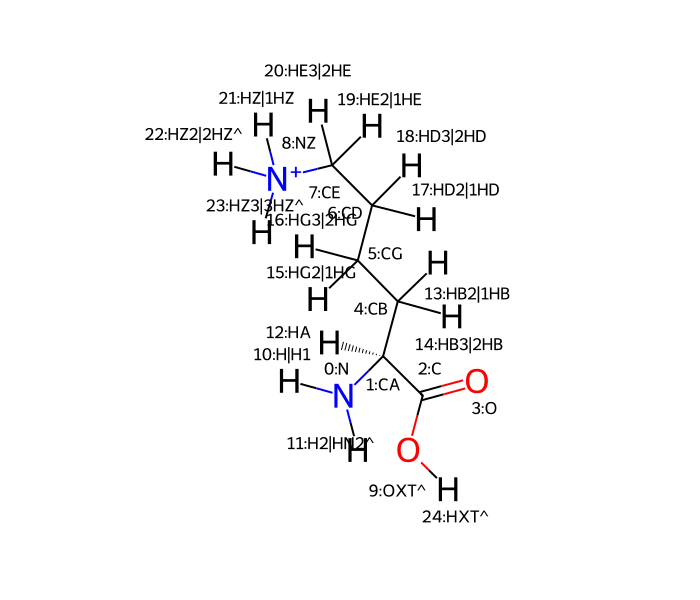

In [64]:
offmol_lys = CCD_RESIDUE_DEFINITION_CACHE['LYS'][0].to_openff_molecule()
for atom in offmol_lys.atoms:
    if atom.name in ("HZ2", "HZ3"):
        
        #print(atom)
        #print(atom.metadata)
        atom.metadata['leaving_atom'] = True
        atom.metadata['substructure_atom'] = False
    if atom.name  == "HZ1":
        atom.name = "HZ"
        #print(atom)

draw_mol_with_atom_names(offmol_lys)

<Atom name='HG' atomic number='1'>
{'residue_name': 'SER', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': ''}


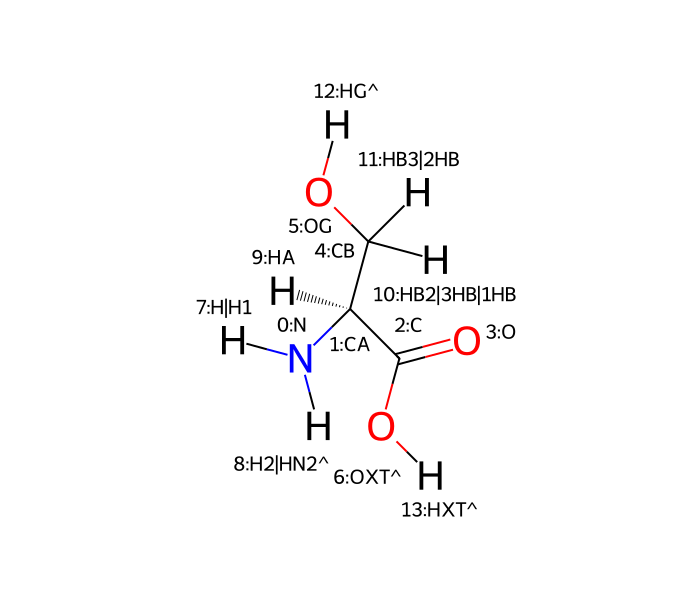

In [65]:
offmol_ser = CCD_RESIDUE_DEFINITION_CACHE['SER'][0].to_openff_molecule()
for atom in offmol_ser.atoms:
    if atom.name=="HG":
        print(atom)
        print(atom.metadata)
        atom.metadata['leaving_atom'] = True
        atom.metadata['substructure_atom'] = False
draw_mol_with_atom_names(offmol_ser)

<Atom name='OD2' atomic number='8'>
{'residue_name': 'ASP', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': ''}
<Atom name='HD2' atomic number='1'>
{'residue_name': 'ASP', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': ''}


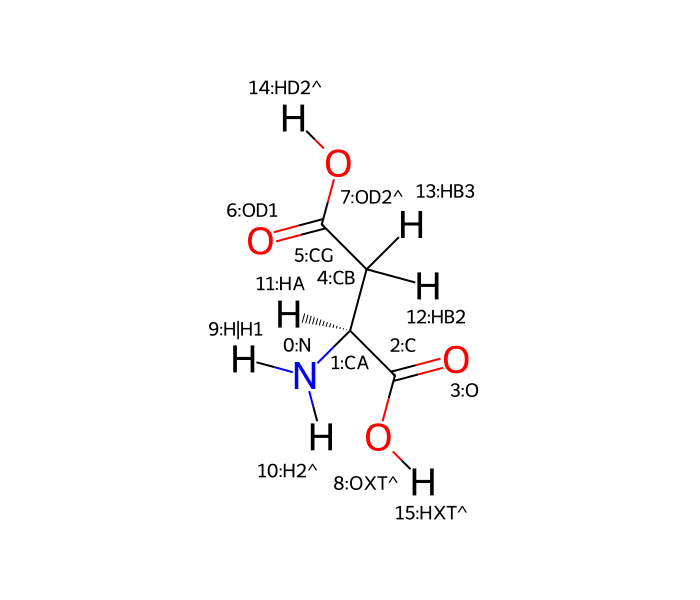

In [66]:
offmol_asp = CCD_RESIDUE_DEFINITION_CACHE['ASP'][0].to_openff_molecule()
for atom in offmol_asp.atoms:
    if atom.name=="OD2" or atom.name=="HD2":
        print(atom)
        print(atom.metadata)
        atom.metadata['leaving_atom'] = True
        atom.metadata['substructure_atom'] = False
draw_mol_with_atom_names(offmol_asp)

<Atom name='OE2' atomic number='8'>
{'residue_name': 'GLU', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': ''}
<Atom name='HE2' atomic number='1'>
{'residue_name': 'GLU', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': ''}


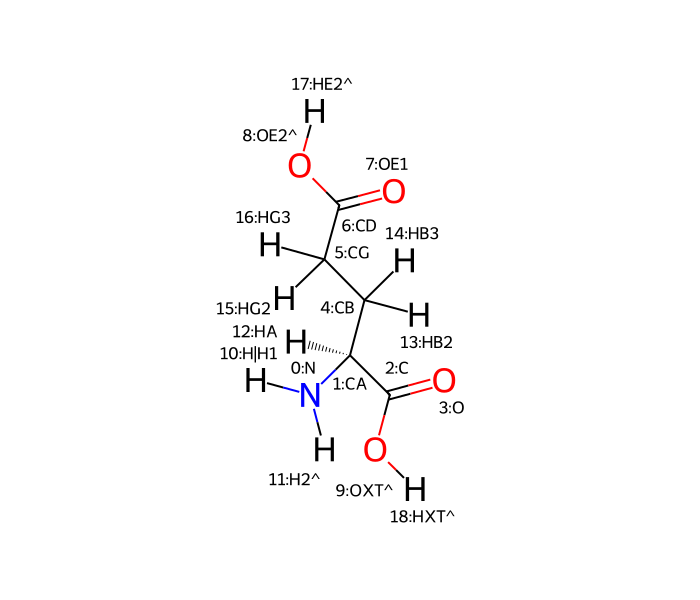

In [67]:
offmol_glu = CCD_RESIDUE_DEFINITION_CACHE['GLU'][0].to_openff_molecule()
for atom in offmol_glu.atoms:
    if atom.name=="OE2" or atom.name=="HE2":
        print(atom)
        print(atom.metadata)
        atom.metadata['leaving_atom'] = True
        atom.metadata['substructure_atom'] = False
draw_mol_with_atom_names(offmol_glu)

In [72]:
offmol_glu.properties

{'linking_bond': BondDefinition(atom1='C', atom2='N', order=1, aromatic=False, stereo=None),
 'crosslink': None,
 'description': 'GLUTAMIC ACID'}

In [78]:
# LYS6 to GLU13 
from openff.pablo.residue import BondDefinition
G13_L6 = BondDefinition(
    atom1="CD",
    atom2="NZ",
    order=1,
    aromatic=False,
    stereo=None,
)
glu_resdef = ResidueDefinition.from_molecule(
    molecule=offmol_glu,
    residue_name="GLU",
    linking_bond=PEPTIDE_BOND,
    crosslink=G13_L6
)

In [ ]:
topology = topology_from_pdb(
    "system_renamed_residues.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"THR": [dye_resdef]}),
)

KeyError: ''

In [69]:
import openff.pablo
dir(openff.pablo.ResidueDefinition)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_leaving_fragment_of',
 '_validate',
 'atoms_bonded_to',
 'crosslink_leaving_atoms',
 'from_capped_molecule',
 'from_molecule',
 'from_smiles',
 'name_to_atom',
 'posterior_bond_leaving_atoms',
 'posterior_bond_linking_atom',
 'prior_bond_leaving_atoms',
 'prior_bond_linking_atom',
 'replace',
 'to_openff_molecule']

We now have a standard OpenFF `Topology` object, which we can visualize with the familiar methods:

In [16]:
w = topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.5, crossSize=1.0)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

/Users/jeffreywagner/micromamba/envs/openff_ptm_prototype/lib/python3.11/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


NGLWidget()

Note that the new PDB loader is much faster than the existing implementation - and the difference is even more dramatic with solvated PDB files. If you'd prefer to be able to identify a custom residue by CONECT records rather than atom names, a residue definition can easily be converted to an OpenFF molecule appropriate for use with the existing `Topology.from_pdb()` method's experimental `_additional_substructures` argument:

In [ ]:
substructure_mol = dye_resdef.to_openff_molecule()

In [ ]:
legacy_topology = Topology.from_pdb(
    "3ip9_dye.pdb",
    _additional_substructures=[substructure_mol],
)

In [ ]:
w = legacy_topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.5, crossSize=1.0)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

## Solvate with the OpenFF PackMOL wrapper

Now that we have an OpenFF `Topology` of the post-translationally modified protein, we can solvate it in familiar ways. For example, with the `solvate_topology` function from the experimental Interchange PackMOL wrapper:

In [ ]:
topology = solvate_topology(
    topology,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.2, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)

In [ ]:
w = topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.5, crossSize=1.0)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

Note that this box requires NPT equilibration before production simulation.

## Parametrize the solvated system using a combination of the Sage and FF14sb force fields and the NAGL graph charge package

The final new component of the prototype is the "swiss cheese" parametrization method. This refers to applying library charges to the parts of the protein for which they are defined in the ff14sb force field, and "filling in the holes" with NAGL graph charges. This is a streamlined stopgap to a more natural direct parametrization to a future force field that supports both proteins and NAGL charges natively. Note that this produces a bit of a Frankenstein's monster of a parametrization; while NAGL charges are philosophically compatible with both Sage and Amber force fields, and Sage and Amber force fields are philosophically compatible with each other, the actual quality of the resulting simulations has never been rigorously tested and might hold some surprises! If you perform such testing, please [let us know!]

This'll take a few minutes; graph charges are much faster than quantum chemical methods, but a protein is still a large molecule.

[let us know!]:https://github.com/openforcefield/ptm_prototype/issues/new

In [ ]:
from ptm_prototype import parametrize_with_nagl

sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")

interchange = parametrize_with_nagl(force_field=sage_ff14sb, topology=topology)

## Run a short simulation in OpenMM

Now that we have an Interchange, we can prepare simulations in any of the usual output engines. Here we'll use OpenMM. We'll also save a copy of the system to disk so we have an exact record of what we simulated. We're not aiming to tell you how to run a simulation here, just demonstrate what we can do; you'll need much more substantial equilibration to clean up the PackMOL box.

In [ ]:
from ptm_prototype import get_openmm_total_charge

temperature = 300 * openmm.unit.kelvin
pressure = 1 * openmm.unit.bar

timestep = 2 * openmm.unit.femtosecond
friction_coeff = 1 / openmm.unit.picosecond
barostat_frequency = 25

print("making OpenMM simulation ...")
simulation = interchange.to_openmm_simulation(
    integrator=openmm.LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        timestep,
    ),
    additional_forces=[
        openmm.MonteCarloBarostat(
            pressure,
            temperature,
            barostat_frequency,
        ),
    ],
)

dcd_reporter = openmm.app.DCDReporter("trajectory.dcd", 100)
simulation.reporters.append(dcd_reporter)

print(f"total system charge is {get_openmm_total_charge(simulation.system)}")

print("serializing OpenMM system ...")
with open("system.xml", "w") as f:
    f.write(openmm.XmlSerializer.serialize(simulation.system))

Minimize the energy:

In [ ]:
simulation.context.computeVirtualSites()
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(simulation.integrator.getTemperature())

Run the simulation for a minute of wall time:

In [ ]:
simulation.runForClockTime(1.0 * openmm.unit.minute)

Finally, visualize the resulting trajectory in NGLView!

In [ ]:
from ptm_prototype import nglview_show_openmm

w = nglview_show_openmm(simulation.topology, "trajectory.dcd")
w.add_licorice("DYE", radius=0.3)
w.center("DYE")
w